# Off-Topic Detector (OTD) Activation Statistics

This notebook summarizes the analysis of off-topic detectors used in the ESR ablation experiments (AGI-1516 Experiment 3).

## Background

The original ESR ablation experiment used 26 unique off-topic detector latents, sourced from an earlier experiment (AGI-1138) that used Goodfire's now-deprecated `contrast()` API.

Investigation revealed these latents came from **two different contrast experiments**:
1. **Shuffling Contrast** - latents that activate more on off-topic (shuffled) responses
2. **ESR Contrast** - latents involved in the self-correction mechanism itself

This mixed provenance meant some latents were true off-topic detectors while others were self-correction triggers.

## New Selection Methodology

We developed a clear, reproducible methodology using **Separability (AUC-ROC)**:

- **Definition**: Separability = P(shuffled activation > normal activation)
- **Selection criterion**: Separability = 1.0 (perfect separation)
- **Result**: 25 latents with perfect off-topic detection

### Overlap Analysis

- **13 latents** overlap between the original 26 and the new 25
- **10 original latents** cannot be recovered via separability alone
- These 10 "missing" latents have labels suggesting they're self-correction triggers, not off-topic detectors:
  - 15375: "Expressions of dismay or realizing mistakes"
  - 27331: "The assistant is positioning itself as helpful"
  - 41038: "Assistant response needs termination due to repetition"

## Ablation Results

We ran the full ablation experiment (~4300 trials) comparing the separability-based OTDs against baseline:

| Condition | MSI | Multi-attempt % | ESR Reduction |
|-----------|-----|-----------------|---------------|
| Baseline (no ablation) | 0.53 | 1.60% | - |
| **Separability ablation (25 OTDs)** | **0.24** | **0.78%** | **54%** |

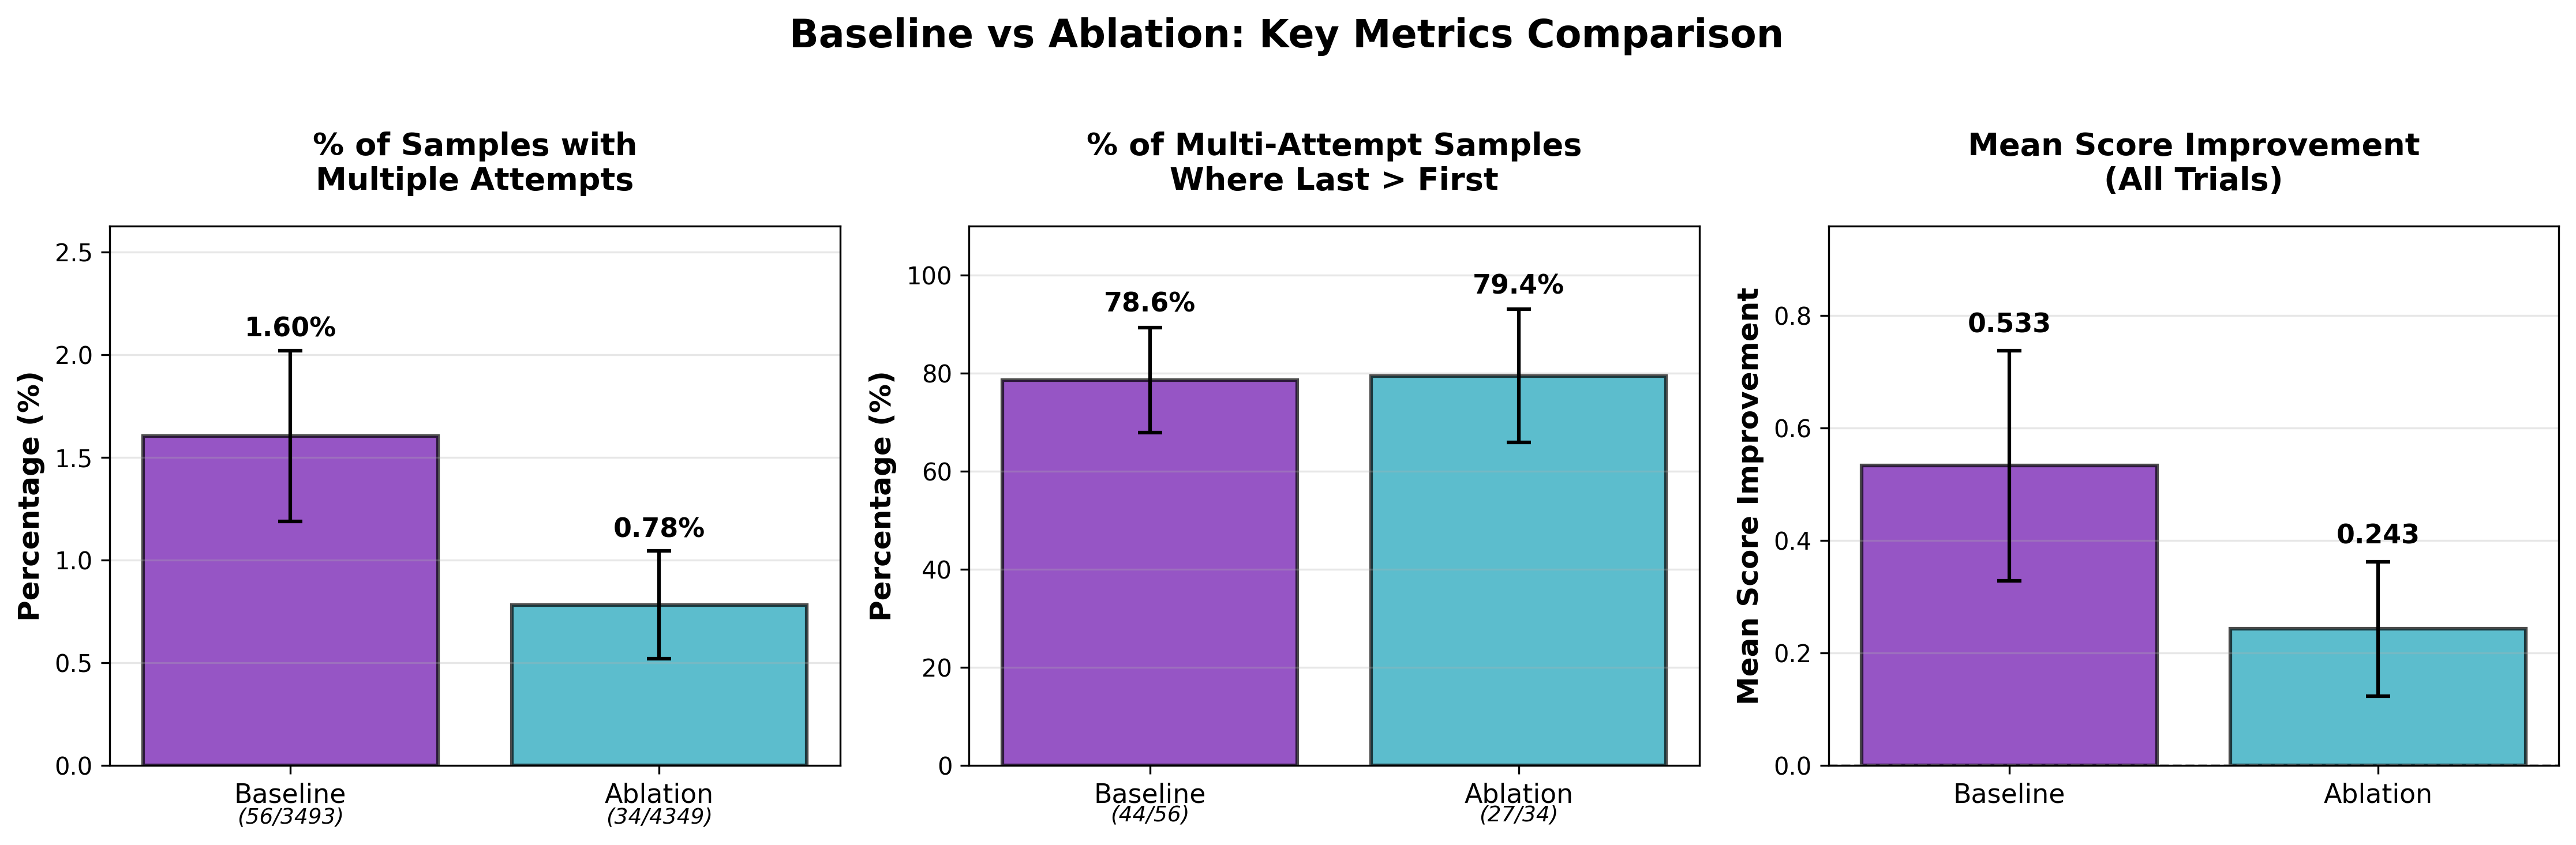

In [1]:
from IPython.display import Image, display

display(Image(filename='../plots/experiment_3_ablation_metrics_bar_chart_combined_25latents.png'))

**Key finding**: The separability-based OTDs reduce ESR by ~54%. This is achieved using only latents with perfect separability (AUC-ROC = 1.0) between shuffled and normal prompt-response pairs.

The 25 separability-based detectors are a "purer" set - they are definitionally off-topic detectors (they perfectly distinguish off-topic from on-topic responses).

## OTD Activation Statistics

The table below shows activation statistics for each of the 25 separability-based off-topic detectors. All latents activate on 100% of shuffled (off-topic) pairs while having minimal activation on normal (on-topic) pairs.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

# The 25 separability-based off-topic detectors
OFF_TOPIC_DETECTORS = [
    6527, 7517, 9005, 10304, 11390, 17250, 17481, 17516, 23093, 24684,
    26312, 28403, 28540, 37234, 37536, 38956, 39926, 40119, 40792, 44845,
    45078, 56830, 58565, 59483, 61420
]

DATA_DIR = Path("../data")
ZERO_THRESHOLD = 1e-8

# Load activations
data = np.load(DATA_DIR / "activations_all_latents.npz")
normal_activations = data["normal"]
shuffled_activations = data["shuffled_0"]

# Load labels
labels_df = pd.read_csv(DATA_DIR / "llama-70b-goodfire-l50.csv")
labels = dict(zip(labels_df['index_in_sae'], labels_df['label']))

# Compute statistics for each OTD
rows = []
for latent_idx in OFF_TOPIC_DETECTORS:
    shuffled_vals = shuffled_activations[:, latent_idx]
    normal_vals = normal_activations[:, latent_idx]
    
    rows.append({
        "Latent": latent_idx,
        "Label": labels.get(latent_idx, "")[:50],
        "Shuffled Mean": shuffled_vals.mean(),
        "Shuffled % Active": (shuffled_vals > ZERO_THRESHOLD).mean() * 100,
        "Normal Mean": normal_vals.mean(),
        "Normal % Active": (normal_vals > ZERO_THRESHOLD).mean() * 100,
    })

df = pd.DataFrame(rows)
df.style.format({
    "Shuffled Mean": "{:.3f}",
    "Shuffled % Active": "{:.1f}%",
    "Normal Mean": "{:.3f}",
    "Normal % Active": "{:.1f}%",
})

## Conclusion

By using a principled separability-based selection criterion, we identified 25 latents that perfectly distinguish off-topic from on-topic responses. Ablating these latents reduces ESR by 54%, demonstrating that off-topic detection is a key component of the endogenous steering resistance mechanism.

The new detector set is "purer" than the original - it excludes latents that may have been self-correction triggers rather than true off-topic detectors.